# Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

import ast
import requests

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import random

## GYM SET

In [2]:
df_gym = pd.read_csv("megaGymDataset.csv")
df_gym

,Unnamed: 0,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,NaN
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.1,Average
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner,8.1,Average
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN


In [3]:
df_gym["Equipment"].unique()

array(['Bands', 'Barbell', 'Kettlebells', 'Dumbbell', 'Other', 'Cable',
       'Machine', 'Body Only', 'Medicine Ball', 'None', 'Exercise Ball',
       'Foam Roll', 'E-Z Curl Bar'], dtype=object)

In [4]:
#split dataset in features and target variable
feature_cols = [ "Title",	"BodyPart", "Equipment", "Level",	"Rating",	"RatingDesc" ]
X = df_gym[feature_cols] # Features
y = df_gym["Type"] # Target variable

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
X_train

,Title,BodyPart,Equipment,Level,Rating,RatingDesc
653,Alternating Exercise Ball Knee Tucks - Gethin ...,Abdominals,Exercise Ball,Intermediate,NaN,NaN
1895,Goblet squat-,Quadriceps,Kettlebells,Intermediate,NaN,NaN
708,Close-grip EZ-bar curl,Biceps,Barbell,Beginner,8.9,Average
1305,Romanian Deadlift,Hamstrings,Barbell,Intermediate,8.1,Average
23,Kettlebell 3-point leg extension,Abdominals,Kettlebells,Intermediate,0.0,NaN
...,...,...,...,...,...,...
2763,Side Wrist Pull,Shoulders,None,Beginner,8.4,Average
905,Knee Circles,Calves,Body Only,Beginner,6.3,Average
1096,30 Chest Shoulder-Height Cable Fly,Chest,Cable,Intermediate,NaN,NaN
235,Hanging leg raise with throw down,Abdominals,Body Only,Beginner,0.0,NaN


In [7]:
# # Create Decision Tree classifer object
# clf_gym = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf_gym = clf_gym.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf_gym.predict(X_test)

In [8]:
X_test

,Title,BodyPart,Equipment,Level,Rating,RatingDesc
473,Holman Feet-Elevated Up-Down Elbow Plank,Abdominals,Body Only,Intermediate,NaN,NaN
2101,UP Quad Extension,Quadriceps,Machine,Intermediate,NaN,NaN
1703,Inverted Row with Straps,Middle Back,Other,Beginner,6.4,Average
303,Frog kick,Abdominals,Body Only,Intermediate,NaN,NaN
664,FYR2 Standing Banded Leg Abduction,Abductors,Bands,Intermediate,NaN,NaN
...,...,...,...,...,...,...
242,Suspended Crunch,Abdominals,Body Only,Beginner,0.0,Average
2727,Upward Stretch,Shoulders,Body Only,Intermediate,6.7,Average
370,HM Inchworm,Abdominals,Body Only,Intermediate,NaN,NaN
2571,FYR Dumbbell front raise to lateral raise,Shoulders,Dumbbell,Intermediate,NaN,NaN


In [9]:
# y_pred

In [10]:

# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(df_gym['Type'].nunique())

cats = [ "Type",  "Equipment", "Level", "RatingDesc" ]

df_gym_cat = df_gym

for cat in cats:
  codes, uniques = pd.factorize( df_gym_cat[cat] )
  df_gym_cat[cat] = codes
df_gym_cat['Rating'] = df_gym_cat['Rating'].fillna(0)

codes, uniques = pd.factorize( df_gym['Type'] )
# for i in codes:
#   print(i)

7


In [11]:
df_gym_cat

,Unnamed: 0,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,0,Abdominals,0,0,0.0,-1
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,0,Abdominals,0,0,0.0,-1
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,0,Abdominals,0,0,0.0,-1
3,3,Banded crunch,The banded crunch is an exercise targeting the...,0,Abdominals,0,0,0.0,-1
4,4,Crunch,The crunch is a popular core exercise targetin...,0,Abdominals,0,0,0.0,-1
...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,0,Triceps,12,0,8.1,0
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,0,Triceps,12,1,8.1,0
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,0,Triceps,12,0,0.0,-1
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,0,Triceps,12,0,0.0,-1


In [12]:
df_gym_cat["BodyPart"].unique()

array(['Abdominals', 'Adductors', 'Abductors', 'Biceps', 'Calves',
       'Chest', 'Forearms', 'Glutes', 'Hamstrings', 'Lats', 'Lower Back',
       'Middle Back', 'Traps', 'Neck', 'Quadriceps', 'Shoulders',
       'Triceps'], dtype=object)

In [13]:
# df_gym[df_gym["Type"] == "Cardio"]

# df_gym.groupby('BodyPart').count()
feature_cols = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ]

parts = df_gym_cat['BodyPart'].unique()

models = []
partial_dfs = []

for part in parts:
  temp_df = df_gym_cat[df_gym["BodyPart"] == part]
  temp_df.insert(0, 'New_ID', range(1, 1 + len(temp_df)))

  codes, uniques = pd.factorize( temp_df['Type'] )
  temp_df['Type'] = codes


  # print(temp_df['Type'].astype('category').cat.categories , "\n")

  X = temp_df[feature_cols] # Features
  y = temp_df["New_ID"] # Target variable

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
  print(X_train)

    # Create Decision Tree classifer object
  clf_gym = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf_gym = clf_gym.fit(X_train,y_train)

  #Predict the response for test dataset
  y_pred = clf_gym.predict(X_test)

  

  lst = [[0,	0,	0,	0.0,	-1]]
  df_test = pd.DataFrame(lst, columns = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ])
  df_test
    
  y_sing = clf_gym.predict(df_test)
  # print("Result: ", y_sing[0], " ")

  # df.loc[df['column_name'] == some_value]

  # print(type( temp_df.loc[temp_df['New_ID'] == y_sing[0]] ))

  # print("RES_NAME: ", temp_df.loc[temp_df['New_ID'] == y_sing[0]]['Title'] )
  models.append(clf_gym)
  partial_dfs.append(temp_df)

     Type  Equipment  Level  Rating  RatingDesc
440     0          7      0     0.0          -1
587     0          7      0     0.0          -1
472     0          7      0     0.0          -1
378     0          7      0     0.0          -1
483     0          7      0     0.0          -1
..    ...        ...    ...     ...         ...
144     0          4      0     0.0          -1
645     0          5      0     0.0          -1
72      0          3      0     0.0          -1
235     0          7      1     0.0          -1
37      0          2      0     0.0          -1

[463 rows x 5 columns]
     Type  Equipment  Level  Rating  RatingDesc
669     0          6      0     9.0           0
666     1         11      1     4.0           0
697     0          7      0     0.0          -1
662     0          0      1     8.6           0
699     1          9      1     3.6           0
698     1          9      1     7.1           0
681     2          7      0     0.0          -1
678     1       

<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

     Type  Equipment  Level  Rating  RatingDesc
769     0          3      0     0.0          -1
728     0          1      0     0.0          -1
758     0          3      0     0.0          -1
853     0          7      0     0.0          -1
766     0          3      0     0.0          -1
..    ...        ...    ...     ...         ...
833     0          5      0     0.0          -1
837     0          5      0     0.0          -1
772     0          3      0     0.0          -1
840     0          5      0     0.0          -1
737     0          3      1     8.9           0

[117 rows x 5 columns]
     Type  Equipment  Level  Rating  RatingDesc
902     0          6      0     0.0          -1
895     0          6      0     0.0          -1
889     0          6      0     8.7           0
881     0          4      0     7.4           0
906     1          7      0     5.6           0
885     0          4      0     0.0          -1
910     0          7      0     0.0          -1
872     0       

<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni


      Type  Equipment  Level  Rating  RatingDesc
1369     4          7      0     8.3           0
1327     2          2      1     0.0          -1
1308     0          1      1     0.0           0
1409     2         10      0     0.0          -1
1316     2          1      0     0.0          -1
...    ...        ...    ...     ...         ...
1298     3          1      1     8.9           0
1361     2          6      0     0.0          -1
1301     3          1      1     8.5           0
1396     2          7      0     0.0          -1
1326     2          2      1     0.0          -1

[84 rows x 5 columns]
      Type  Equipment  Level  Rating  RatingDesc
1420     0          1      0     0.0          -1
1522     0          7      0     0.0          -1
1442     0          3      0     0.0          -1
1492     0          5      0     0.0          -1
1448     0          3      0     0.0          -1
...    ...        ...    ...     ...         ...
1419     0          1      1     0.0         

<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni


      Type  Equipment  Level  Rating  RatingDesc
1778     1          7      0     4.8           0
1762     0          4      1     9.3           0
1776     0          7      1     6.4           0
1775     0          7      1     7.4           0
1777     0          7      1     5.7           0
      Type  Equipment  Level  Rating  RatingDesc
1995     0          3      0     0.0          -1
1855     0          1      0     0.0          -1
2158     4          7      0     0.0          -1
2263     0          7      0     0.0          -1
1842     3          1      1     0.0           0
...    ...        ...    ...     ...         ...
1910     0          2      0     0.0          -1
1925     0          3      0     0.0           0
1853     0          1      0     0.0          -1
2016     0          4      0     0.0           0
1818     0          1      0     8.4           0

[452 rows x 5 columns]
      Type  Equipment  Level  Rating  RatingDesc
2505     0          2      1     0.0        

<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes
<ipython-input-13-52eb9d35cf60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Type'] = codes


In [14]:
# print(models)

## USER CODE

In [15]:
import enum

In [16]:

calories1 = pd.read_excel("cal_table.xlsx")
calories1.drop("Наименование", axis=1)
calories3 = pd.read_excel("foods.xlsx")


In [17]:
calories1.rename(columns={'Name': 'food', 
                          'Protein': 'Protein, g', 
                          'Fat': 'Fat, g',
                          'Carbs': 'Carbs, g', 
                          'Calories': 'Calories, kcal'}, inplace=True)
# calories1

In [18]:
# calories3

In [19]:
calories = pd.concat([calories1, calories3])
calories.drop("Наименование", axis=1)
calories.reset_index(drop=True)

,Наименование,food,"Protein, g","Fat, g","Carbs, g","Calories, kcal"
0,Абрикосы,apricots,1.0,0.0,10.0,45
1,Авокадо,Avocado,2.0,19.0,7.0,197
2,Аджика,Adjika,2.0,3.0,8.0,59
3,Айва,Quince,1.0,0.0,9.0,41
4,Айсберг,Iceberg,1.0,0.0,2.0,17
...,...,...,...,...,...,...
1387,NaN,Fried egg,18.8,7.6,3.1,213
1388,NaN,Egg powder,20.9,12.9,0.9,243
1389,NaN,boiled egg,37.3,46.0,4.5,542
1390,NaN,Egg with mayonnaise,11.5,12.7,0.7,157


In [20]:
gym_activities = pd.read_excel("gym_activities.xlsx") # calories burnt per 30 minutes
gym_activities

,Gym Activities,125-pound person,155-pound person,185-pound person
0,Weight Lifting: general,90,108,126
1,Aerobics: water,120,144,168
2,"Stretching, Hatha Yoga",120,144,168
3,Calisthenics: moderate,135,162,189
4,Aerobics: low impact,165,198,231
...,...,...,...,...
92,Playing w/kids: moderate effort,114,141,168
93,"Heavy Cleaning: wash car, windows",135,162,189
94,"Paint, paper, remodel: inside",142,176,210
95,Moving: household furniture,170,211,252


In [21]:
import difflib as difflib
import random

def get_calories(food):
  foods = difflib.get_close_matches(food, calories["food"], n=10, cutoff=0.45)
  # print(foods)
  if foods:
    food_cal = calories[calories["food"] == foods[0]]
    # print(food_cal)
    print(food_cal.values.tolist())
    return food_cal.values.tolist()[0][-1]
  print(f"Food {food} not found!")
  return None

def recommend_exercise(calories_proficit, weight, gym_activities):
  # calories are per 30 minutes
  print(f"You are {calories_proficit} kcal overlimit")
  suggestions = gym_activities[gym_activities["155-pound person"] <= calories_proficit]
  # print(suggestions)
  suggestions = suggestions.sample(len(suggestions) // 3 ).sort_values(by=['155-pound person'], ascending=False)
  # print(suggestions)
  recommendation = "The following activites can be suggested:\n"
  for item in suggestions.iterrows():
    # print("HERE: ", item[1].tolist())

    cal_coef = item[1][1] + (item[1][2] - item[1][1]) / (155-125) * abs(155 - weight*2.205)
    # print(f"{item[1][1]}, {item[1][2]}, {weight*2.205}")

    recommendation += f'{item[1][0]} for { int( calories_proficit / ( cal_coef  / 30 ) ) } minutes\n'
  print(recommendation)


def get_exercise(ex, body_part):
  # print(df_gym_cat[df_gym_cat["BodyPart"] == body_part]["Title"])
  exes = difflib.get_close_matches(ex, df_gym_cat[df_gym_cat["BodyPart"] == body_part]["Title"], n=10, cutoff=0.3)
  # print(exes)
  if exes:
    # print("Exes: ", exes)
    # chosen = random.choice(exes)
    # exercise = df_gym_cat[df_gym_cat["Title"] == chosen]
    exercises = [ df_gym_cat[df_gym_cat['Title'] == x] for x in exes ]
    # print(exercise)
    # print(exercise.values.tolist())
    return exercises
  print(f"Exercises close to {ex} not found!")
  return None
  
a = get_exercise("Bench", "Chest")
# print(a)

recommend_exercise(150, 70, gym_activities)

# enter foods
# calc summ of calories
# suggest exercise or what else to eat?


You are 150 kcal overlimit
The following activites can be suggested:
Raking lawn for 37 minutes
Walking: 3.5 mph (17 min/mi) for 41 minutes
Food Shopping: with cart for 52 minutes
Cooking for 78 minutes
Horseback Riding: general for 78 minutes
Reading: sitting for 131 minutes
Sleeping for 236 minutes



In [22]:
# apptoken= "RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz"

# api-mifit-de2.huami.com/v1/data/band_data.json
# https://api-mifit-de2.huami.com/v1/sport/run/history.json

# def get_history():
#     r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/history.json', headers={
#         'apptoken': apptoken
#     }, params={
#         'source': 'run.mifit.huami.com',
#     })
#     r.raise_for_status()

    # return r.json()
# exercise_history = get_history()
# exercise_history

In [23]:
running_heartrate = pd.read_csv("running_summary.csv")

In [24]:
running_heartrate = running_heartrate[['heart_rate', 'total_running_time', 'total_calories', 'distance', 'avg_speed']].dropna()


In [25]:
running_train_dataset = running_heartrate.sample(frac=0.8, random_state=0)
running_test_dataset = running_heartrate.drop(running_train_dataset.index)

In [26]:
# running_train_dataset

In [27]:
# running_test_dataset

In [28]:
running_train_features = running_train_dataset.copy()
running_test_features = running_test_dataset.copy()

running_train_labels = running_train_features.pop('heart_rate')
running_test_labels = running_test_features.pop('heart_rate')

In [29]:
running_train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
heart_rate,4402.0,149.030441,16.316665,63.000000,139.250000,150.000000,161.000000,205.000000
total_running_time,4402.0,1957.333485,1517.648537,1.000000,903.000000,1597.000000,2580.250000,14263.000000
total_calories,4402.0,81.807133,32.021867,0.000000,79.000000,92.000000,100.000000,219.000000
distance,4402.0,7.112361,5.391902,0.090060,3.220842,6.437385,9.657105,41.844780
avg_speed,4402.0,12.832776,1.199456,9.454794,11.999926,12.642837,13.568232,19.840473


In [30]:


normalizer = tf.keras.layers.Normalization(axis=-1)

In [31]:
normalizer.adapt(np.array(running_train_features))
print(normalizer.mean.numpy())

first = np.array(running_train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


[[1957.3331      81.807144     7.1123595   12.832772 ]]
First example: [[2922.     75.      9.66   11.74]]

Normalized: [[ 0.64 -0.21  0.47 -0.91]]


In [32]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [33]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [34]:
%%time
history = dnn_model.fit(
    running_train_features,
    running_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

# def plot_loss(history):
#   plt.plot(history.history['loss'], label='loss')
#   plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error [MPG]')
#   plt.legend()
#   plt.grid(True)

# plot_loss(history)

CPU times: user 34.2 s, sys: 1.23 s, total: 35.4 s
Wall time: 1min 23s


In [35]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(running_test_features, running_test_labels, verbose=0)
# print(test_results)

In [36]:
# running_test_features

In [37]:
# test_person.calc_heartrate(dnn_model, ex)

In [38]:
# ex = exercise_history["data"]["summary"][0]
# print(ex["dis"])
# print( (float(ex["dis"]) / 1000) / (float(ex["run_time"]) / 3600))
# print(ex["total_step"])
# print(ex["calorie"])
# print(ex["run_time"])
# print(ex["avg_heart_rate"])
# dis - distance
# calorie
# run_time - in sec
# avg_heart_rate
# total_step

In [39]:
import datetime

class Training_Program():
  history = []

class Gender(enum.Enum):
  male = "male"
  female = "female"

class User:
  def __init__(self, name, age, height, weight, gender, ex_type=0, equip=0, level=0):
    self.name = name
    self.age = age
    self.height = height
    self.weight = weight
    self.gender = Gender(gender)
    self.BMI = self.calculate_BMI()

# add calories depending on age
    self.calories_intake = 3000 if self.gender == Gender.male else 2400 
    self.calories_today = 0
    

    self.ex_type = ex_type
    self.equip = equip
    self.level = level

    self.program = None

    self.history = None

  def __str__ (self):
    s = f"""Name: {self.name},
    Age: {self.age},
    Height: {self.height},
    Weight: {self.weight},
    Gender: {self.gender},
    Calories daily: {self.calories_intake},
    Calories today: {self.calories_today},
    BMI: {self.BMI}\n"""

    if self.program:
      s += self.show_program()
    
    return s



# if BMI <= 18.4:
#     print("You are underweight.")
# elif BMI <= 24.9:
#     print("You are healthy.")
# elif BMI <= 29.9:
#     print("You are over weight.")
# elif BMI <= 34.9:
#     print("You are severely over weight.")
# elif BMI <= 39.9:
#     print("You are obese.")
# else:
#     print("You are severely obese.")

  def calculate_BMI(self):
    return self.weight / (self.height/100)**2

  def generate_program(self):
    exercises = {}
    for i in range(len(models)):
      body_part = parts[i]
      model = models[i]
      table = partial_dfs[i]

      lst = [[self.ex_type,	self.equip,	self.level,	0.0,	-1]]
      df_test = pd.DataFrame(lst, columns = [ "Type", "Equipment", "Level",	"Rating",	"RatingDesc" ])
      # print(df_test)

      exercise = model.predict(df_test)
      id = table.index[table['New_ID'] == exercise[0]][0]
      # print("ID: ", id, ", RES_NAME: ", table.loc[table['New_ID'] == exercise[0]]['Title'] )
      # print("ID: ", id, ", RES_NAME: ", df_gym.iloc[[id]]['Title'].tolist()[0] )
      exercises[body_part] = df_gym.iloc[[id]]
    # for i in exercises.keys():
    #   print(f"For bodypart {i}, recommend { exercises.get(i)['Title'].tolist()[0]}")

    # print("TEST: ", exercises["Adductors"] )

    self.program = exercises

    # columns = [x['Title'].tolist()[0] for x in self.program.values()]
    columns = []
    for x in self.program.values():
      y = x['Title'].tolist()[0]
      columns.append(f"{y}, reps")
      columns.append(f"{y}, weight (kg)")
      columns.append(f"{y}, rest (s)")


    # print("TEST: ", columns)

    self.history = pd.DataFrame(columns=columns)
    self.history.insert(0, "Training_number", None)
    self.history.insert(0, "Date", None)

  def show_program(self):
    s = ""
    for i in self.program.keys():
      s += f"For bodypart {i}, recommend { self.program.get(i)['Title'].tolist()[0]}\n"
    return s

  def reset_calories_today(self):
    self.calories_today = 0

  def set_calories_limit(self, limit):
    self.calories_intake = limit


  def calories_calculation(self, foods):
    # cals = 0
    for food in foods:
      self.calories_today += get_calories(food)

    print(f"Total {self.calories_today} kcal eaten today")
    if self.calories_today > self.calories_intake:
      print(f"You are over limit on daily calories, recommend an exercise")
      recommend_exercise(self.calories_today - self.calories_intake, self.weight, gym_activities)
      
    elif self.calories_today < self.calories_intake:
      print(f"Some foods you can eat today:")
      food_vars = calories[calories["Calories, kcal"] <= (self.calories_intake - self.calories_today)]
      print(type(food_vars))
      # for food in food_vars.sort_values(by=['Calories, kcal'], ascending=False):
      #   print(f'{food}')
      for index, row in food_vars.iterrows():
        print(f"{row['food']}, kilo calories - {row['Calories, kcal']}")
        if index >= 10:
          break

      
      # print(food_vars.sort_values(by=['Calories, kcal'], ascending=False).head())

  
  def get_history(self):
    apptoken = "RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz"

    r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/history.json', headers={
        'apptoken': apptoken
    }, params={
        'source': 'run.mifit.huami.com',
    })
    r.raise_for_status()
    return r.json()

  def calc_heartrate(self, model):
    ex = self.get_history()["data"]["summary"][0]
    dist = float(ex["dis"]) / 1000
    speed = (float(ex["dis"]) / 1000) / (float(ex["run_time"]) / 3600)
    calories = float(ex["calorie"])
    time = float(ex["run_time"])
    heart_rate_real = float(ex["avg_heart_rate"])
    print(f"Dist: {dist}, speed: {speed}, cal: {calories}")
    print(f"Actual H/R: {heart_rate_real}")

    # total_running_time	total_calories	distance	avg_speed
    heart_rate_calculated = model.predict([time, calories, dist, speed])
    print(f"Calculated H/R: {heart_rate_calculated}")

    if heart_rate_calculated - heart_rate_real > 5:
      print("Your heart rate is low")
    elif heart_rate_real - heart_rate_calculated > 5:
      print("Your heartrate is high!")
    else:
      print("Your heartrate is normal")


test_person = User("Name", 25, 179, 100, "female", ex_type=1)
print(test_person)
test_person.generate_program()

food_list = ["Egg", "Pie", "Chicken", "Sandwich, Spaghetti"]

test_person.calories_calculation(food_list)

Name: Name,
    Age: 25,
    Height: 179,
    Weight: 100,
    Gender: Gender.female,
    Calories daily: 2400,
    Calories today: 0,
    BMI: 31.210012171904747

[['Яйца', 'Eggs', 15.0, 13.0, 1.0, 162]]
[['Соленый огурец', 'Pickle', 1.0, 0.0, 3.0, 14]]
[['Курица', 'Chicken', 21.0, 11.0, 1.0, 186]]
[[nan, 'Steamed beef patties', 11.3, 16.7, 5.9, 193]]
Total 555 kcal eaten today
Some foods you can eat today:
<class 'pandas.core.frame.DataFrame'>
apricots, kilo calories - 45
Avocado, kilo calories - 197
Adjika, kilo calories - 59
Quince, kilo calories - 41
Iceberg, kilo calories - 17
Activia kefir 1%, kilo calories - 39
A pineapple, kilo calories - 50
Canned pineapple, kilo calories - 65
candied pineapple, kilo calories - 78
Orange, kilo calories - 43
Orange juice, kilo calories - 44


In [40]:
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"


In [41]:
# For bodypart Abdominals, recommend Banded crunch isometric hold
# For bodypart Adductors, recommend Side-To-Side Adductor Stretch
# For bodypart Abductors, recommend Lateral Band Walk
# For bodypart Biceps, recommend Incline dumbbell biceps curl
# For bodypart Calves, recommend Smith machine standing calf raise
# For bodypart Chest, recommend HM Banded Cross-Over Pull
# For bodypart Forearms, recommend Standing alternating band speed row
# For bodypart Glutes, recommend UNS Banded Glute Bridge
# For bodypart Hamstrings, recommend 30 Legs Sumo Deadlift
# For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
# For bodypart Lower Back, recommend Band good morning-
# For bodypart Middle Back, recommend Partner side plank band row
# For bodypart Traps, recommend Band seated row
# For bodypart Neck, recommend Lying Face Down Plate Neck Resistance
# For bodypart Quadriceps, recommend Boss Everline Resistance-Band Pull Sprint
# For bodypart Shoulders, recommend HM Lateral Raise
# For bodypart Triceps, recommend Band overhead triceps press

In [42]:
def add_training_results_dummy(user, exercise, weight, reps, rest, t_num, date=datetime.datetime(2023, 5, 17)):
  # print([x['Title'].tolist()[0] for x in user.program.values()])
  if not exercise in [x['Title'].tolist()[0] for x in user.program.values()]:
    print("Wrong exercise!")
    return

  # print(user.history.index[user.history['Training_number'] == t_num].tolist())
  # if t_num in user.history["Training_number"]:
  #   print("Yes")
  # else:
  #   # print("no")
  #   # df.loc[len(df)] 
  ind = len( user.history )
  if user.history.index[user.history['Training_number'] == t_num].tolist():
    ind = user.history.index[user.history['Training_number'] == t_num].tolist()[0]

  # user.history.loc[ ind ] = {"Date": date, "Training_number": t_num, f"{exercise}, reps": reps,
  #                                         f"{exercise}, weight (kg)": weight,
  #                                         f"{exercise}, rest (s)": rest}
  user.history.loc[ ind, ["Date"] ] = date
  user.history.loc[ ind, "Training_number" ] = int(t_num)
  user.history.loc[ ind, f"{exercise}, reps"]  = float(reps)
  user.history.loc[ ind, f"{exercise}, weight (kg)" ] = weight
  user.history.loc[ ind, f"{exercise}, rest (s)" ] = rest

  if len(user.history) > 10:
    pass

    # update weights
  # user.history

test_exec = [x['Title'].tolist()[0] for x in test_person.program.values()][0]
test_exec_1 = [x['Title'].tolist()[0] for x in test_person.program.values()][1]
test_exec_2 = [x['Title'].tolist()[0] for x in test_person.program.values()][2]

add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2, date=datetime.datetime(2020, 5, 18))
add_training_results_dummy(test_person, test_exec_1, 10, 26, 42, 2, date=datetime.datetime(2020, 5, 18))

add_training_results_dummy(test_person, test_exec_2, 10, 26, 42, 3, date=datetime.datetime(2020, 5, 19))
add_training_results_dummy(test_person, test_exec_1, 10, 26, 42, 3, date=datetime.datetime(2020, 5, 19))
add_training_results_dummy(test_person, test_exec, 10, 26, 42, 3, date=datetime.datetime(2020, 5, 19))
# add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2)
# add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2)
# add_training_results_dummy(test_person, test_exec, 10, 26, 42, 2)
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
test_person.history["Training_number"]

0    2
1    3
Name: Training_number, dtype: object

In [44]:
def add_training_results(user, exercise, weight, reps, rest, t_num, date=datetime.datetime(2023, 5, 17)):
  # print([x['Title'].tolist()[0] for x in user.program.values()])
  
  if not exercise in [x['Title'].tolist()[0] for x in user.program.values()]:
    print("Wrong exercise!")
    return

  # print(user.history.index[user.history['Training_number'] == t_num].tolist())
  # if t_num in user.history["Training_number"]:
  #   print("Yes")
  # else:
  #   # print("no")
  #   # df.loc[len(df)] 
  ind = len( user.history )
  if user.history.index[user.history['Training_number'] == t_num].tolist():
    ind = user.history.index[user.history['Training_number'] == t_num].tolist()[0]
  
  # user.history.loc[ ind ] = {"Training_number": t_num, f"{exercise}, reps": reps,
  #                                         f"{exercise}, weight (kg)": weight,
  #                                         f"{exercise}, rest (s)": rest}
  
  user.history.loc[ ind, ["Date"] ] = date
  user.history.loc[ ind, "Training_number" ] = t_num
  user.history.loc[ ind, f"{exercise}, reps" ] = float(reps)
  user.history.loc[ ind, f"{exercise}, weight (kg)" ] = weight
  user.history.loc[ ind, f"{exercise}, rest (s)" ] = rest


  if len(user.history) > 10:
    w, b = get_recommended_weights(user.history, exercise)
    # recom = my_output([weight], w, b)[0]
    predict = get_predicted_weight(user.history, my_output, w, b, weight, reps)

    # update weights
  # user.history

add_training_results(test_person, "Lateral Band Walk", 10, 26, 42, 2, date=datetime.datetime(2023, 5, 18))
test_person.history

Wrong exercise!


,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
add_training_results(test_person, "Lazy", 10, 26, 42, 2)
test_person.history

Wrong exercise!


,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# import random

# # filling history with dummy data
# for i in range(10):
#   add_training_results(test_person, "Banded crunch isometric hold", 
#                        round(random.uniform(7, 15), 0), 
#                        round(random.uniform(10, 20), 0), 
#                        round(random.uniform(30, 45), 0),
#                        i)
  
# test_person.history

In [47]:
test_person.program

{'Abdominals':    Unnamed: 0                         Title  \
 1           1  Banded crunch isometric hold   
 
                                                 Desc  Type    BodyPart  \
 1  The banded crunch isometric hold is an exercis...     0  Abdominals   
 
    Equipment  Level  Rating  RatingDesc  
 1          0      0     0.0          -1  ,
 'Adductors':      Unnamed: 0                Title Desc  Type   BodyPart  Equipment  Level  \
 662         662  Band Hip Adductions  NaN     0  Adductors          0      1   
 
      Rating  RatingDesc  
 662     8.6           0  ,
 'Abductors':      Unnamed: 0                      Title Desc  Type   BodyPart  Equipment  \
 679         679  IT Band and Glute Stretch  NaN     3  Abductors          7   
 
      Level  Rating  RatingDesc  
 679      0     2.4           0  ,
 'Biceps':      Unnamed: 0                         Title  \
 700         700  Incline dumbbell biceps curl   
 
                                                   Desc  Type

Добавить - возмодность менять упражнения


In [48]:
import numpy as np

def choose_exercise_num(n):
  choice = -1
  
  while choice < 0 or choice > n:
    try:
      choice = int(input()) - 1
    except:
      print("Please enter a valid number")
  return choice


def change_exercise(user: User, body_part: str, new_exercise: str, gym_set):
  # print()
  # part = gym_set[gym_set["Title"] == old_exercise]["BodyPart"].tolist()[0]
  print(f"Bodypart: {body_part}")
  
  if body_part in list(df_gym_cat["BodyPart"].unique()) :
    ex = get_exercise(new_exercise, body_part=body_part)
    # print("HERE: ", ex)
    print(f"Found following exercises:")
    for i in range(len(ex)):
      print(f"Number {i + 1}) - {list(ex[i]['Title'])[0] }")
    print("Enter the number of the exercise to choose:")

    choice = choose_exercise_num(len(ex))

    title = list(ex[choice]['Title'])[0]
    print(f"Chose exercise {title}")
    
    user.program[body_part] = ex[choice]

    user.history[f"{title}, reps"] = np.nan
    user.history[f"{title}, weight (kg)"] = np.nan
    user.history[f"{title}, rest (s)"] = np.nan
  else:
    print(f"Bodypart {body_part} not found")

# print("Before:")
print(test_person)
# change_exercise(test_person, "Abdominals", "Chest", df_gym_cat)
# print("\n\nAfter:")
# print(test_person)

Name: Name,
    Age: 25,
    Height: 179,
    Weight: 100,
    Gender: Gender.female,
    Calories daily: 2400,
    Calories today: 555,
    BMI: 31.210012171904747
For bodypart Abdominals, recommend Banded crunch isometric hold
For bodypart Adductors, recommend Band Hip Adductions
For bodypart Abductors, recommend IT Band and Glute Stretch
For bodypart Biceps, recommend Incline dumbbell biceps curl
For bodypart Calves, recommend Smith machine standing calf raise
For bodypart Chest, recommend HM Banded Cross-Over Pull
For bodypart Forearms, recommend Standing alternating band speed row
For bodypart Glutes, recommend Alternating standing glute stretch
For bodypart Hamstrings, recommend Standing Hamstring and Calf Stretch
For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
For bodypart Lower Back, recommend Yoga plex
For bodypart Middle Back, recommend Partner side plank band row
For bodypart Traps, recommend Snatch Shrug
For bodypart Neck, recommend Lying Face Down Plate Neck 

In [49]:
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-19 00:00:00,3,26.0,10,42,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
change_exercise(test_person, "1", "2", df_gym_cat)

Bodypart: 1
Bodypart 1 not found


In [51]:
# print(parts)

## Map Search

In [52]:
test_long = 37.44338754155181
test_lat = 55.83872304132719

In [53]:
import json
import requests
from IPython.display import Image

ya_api = "be69a8a0-9ea0-42cf-ad7a-5b73199a308d"

# print(f'https://search-maps.yandex.ru/v1/?text=деревня Толстик&type=geo&lang=ru_RU&apikey={ya_api}')
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={test_long},{test_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=5&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
print(req_str)

x = requests.get(req_str)

print(x.text)

https://search-maps.yandex.ru/v1/?text=Спортивная площадка&ll=37.44338754155181,55.83872304132719&spn=0.552069,0.550552&type=biz&results=5&lang=ru_RU&apikey=be69a8a0-9ea0-42cf-ad7a-5b73199a308d
{"type":"FeatureCollection","properties":{"ResponseMetaData":{"SearchResponse":{"found":50,"display":"multiple","boundedBy":[[37.34433727,55.65505483],[37.62009573,55.93037958]]},"SearchRequest":{"request":"Спортивная площадка","skip":0,"results":5,"boundedBy":[[37.16735304,55.56246844],[37.71942204,56.1130205]]}}},"features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[37.550329,55.807951]},"properties":{"name":"Спортплощадка","description":"Москва, парк Московской сельскохозяйственной академии имени К.А. Тимирязева","boundedBy":[[37.531846,55.805619],[37.562703,55.834512]],"CompanyMetaData":{"id":"28076710863","name":"Спортплощадка","address":"Москва, парк Московской сельскохозяйственной академии имени К.А. Тимирязева","Categories":[{"class":"playground","name":"Спортплощадка"}

In [54]:


# print(json.dumps(x.json()["features"][0]["geometry"]["coordinates"], indent=2))

# x.json()["features"]
def get_all_coordinates(x):
  gym_coordinates = []
  for item in x.json()["features"]:
    # print(item["geometry"]["coordinates"])
    gym_coordinates.append(item["geometry"]["coordinates"])
  return gym_coordinates

gym_coordinates = get_all_coordinates(x)

## Getting the map

In [55]:
# 37.620070,55.753630,pmwtm12~37.64,55.76363,pmwtm99

def points_create(l):
  points = []
  
  for item in l:
    points.append(f"{item[0]},{item[1]},pm2wtm{l.index(item) + 1}")
  return "~".join(points)
# print(gym_coordinates)
# points_create(gym_coordinates)

In [56]:


# map = requests.get("https://static-maps.yandex.ru/1.x/?ll=37.620070,55.753630&size=450,450&z=13&l=map&pt=37.620070,55.753630,pmwtm12~37.64,55.76363,pmwtm99")
# display(Image(map.content))

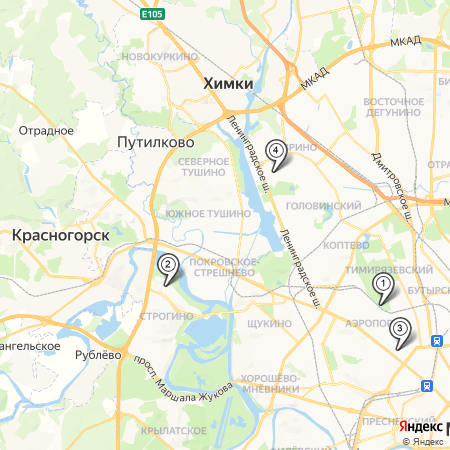

In [57]:

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={test_long},{test_lat}&size=450,450&z=11&l=map&pt={points_create(gym_coordinates)}""")
display(Image(map.content))

In [58]:
# https://static-maps.yandex.ru/1.x/?l=map&pl=37.656577,55.741176,37.656748,55.741419,37.655131,55.741814,37.658257,55.742524,37.659811,55.743066,37.659667,55.743233,37.659551,55.743603,37.659775,55.743928,37.662398,55.745281


## How to get location (Lat and long)

In [59]:

ip_stack_key = "e51b2f79be62ac3ac1f0932cefcd4123"

send_url = f"http://api.ipstack.com/check?access_key={ip_stack_key}"
geo_req = requests.get(send_url)
geo_json = json.loads(geo_req.text)
latitude = geo_json['latitude']
longitude = geo_json['longitude']
city = geo_json['city']
geo_json

{'ip': '35.231.14.182',
 'type': 'ipv4',
 'continent_code': 'NA',
 'continent_name': 'North America',
 'country_code': 'US',
 'country_name': 'United States',
 'region_code': 'SC',
 'region_name': 'South Carolina',
 'city': 'North Charleston',
 'zip': '29418',
 'latitude': 32.890079498291016,
 'longitude': -80.0589370727539,
 'location': {'geoname_id': 4589387,
  'capital': 'Washington D.C.',
  'languages': [{'code': 'en', 'name': 'English', 'native': 'English'}],
  'country_flag': 'https://assets.ipstack.com/flags/us.svg',
  'country_flag_emoji': '🇺🇸',
  'country_flag_emoji_unicode': 'U+1F1FA U+1F1F8',
  'calling_code': '1',
  'is_eu': False}}

Градусы в минуты и секунды

In [60]:
import math

def get_min_sec(rad):
  ans = []
  r = math.floor(rad)
  # print(r)
  ans.append(r)
  m = (rad - math.floor(rad)) * 60
  print(m)
  ans.append(round(m, 4))
  s = round((m - math.floor(m)) * 60, 2)
  print(s)
  ans.append((round(s, 4)))
  return ans

print(test_lat)
get_min_sec(test_lat) 

55.83872304132719
50.32338247963153
19.4


[55, 50.3234, 19.4]

In [61]:
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={test_long},{test_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=70&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
print(req_str)

y = requests.get(req_str)

print(y.text)

https://search-maps.yandex.ru/v1/?text=Спортивная площадка&ll=37.44338754155181,55.83872304132719&spn=0.552069,0.550552&type=biz&results=70&lang=ru_RU&apikey=be69a8a0-9ea0-42cf-ad7a-5b73199a308d
{"type":"FeatureCollection","properties":{"ResponseMetaData":{"SearchResponse":{"found":131,"display":"multiple","boundedBy":[[37.16762908,55.56274564],[37.71914601,56.1127472]]},"SearchRequest":{"request":"Спортивная площадка","skip":0,"results":70,"boundedBy":[[37.16735304,55.56246844],[37.71942204,56.1130205]]}}},"features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[37.550329,55.807951]},"properties":{"name":"Спортплощадка","description":"Москва, парк Московской сельскохозяйственной академии имени К.А. Тимирязева","boundedBy":[[37.531846,55.805619],[37.562703,55.834512]],"CompanyMetaData":{"id":"28076710863","name":"Спортплощадка","address":"Москва, парк Московской сельскохозяйственной академии имени К.А. Тимирязева","Categories":[{"class":"playground","name":"Спортплощадка

In [62]:
import random

lat_start = random.uniform(-0.09, 0.09)
long_start = random.uniform(-0.09, 0.09)
lat_end = random.uniform(-0.09, 0.09)
long_end = random.uniform(-0.09, 0.09)

# Random float number
print(lat_start)


-0.0651506284228956


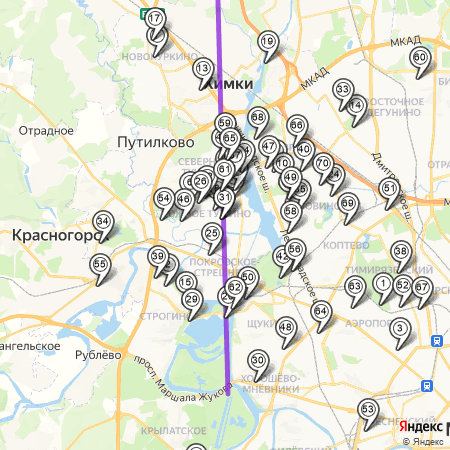

In [63]:


points = get_all_coordinates(y)

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={test_long},{test_lat}&size=450,450&z=11&l=map&pt={points_create(points)}"""\
                   f"&pl={test_long + long_start},{test_lat + lat_start},{test_long + long_end},{test_lat + lat_end}")
display(Image(map.content))


In [64]:
def coord_distance(x1, y1, x2, y2):
  # print(f"{x1}, {y1}, {x2}, {y2}")
  return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def notification_gym_nearby(point, distance):
  print(f"Notification sent, point {point}. distance {round(distance * 100000, 2)}")

In [65]:
# print(test_lat)
# print(test_lat + lat_start)
# print(test_lat + lat_end)


# steps = 100
# for i in range(steps):
#   cur_lat = test_lat + lat_start + (lat_end - lat_start) * i / steps
#   cur_long = test_long + long_start + (long_end - long_start) * i / steps
#   print(f"{cur_long}, {cur_lat}")

In [66]:

flag_point = 0

def find_closes_gym(long, lat, gyms):
  
  global flag_point
  closest = 0
  min_dist = 100
  for j in gyms:
    d = coord_distance(long, lat, j[0], j[1]) 
    # print(min_dist)
    if d < dist:
      if d < min_dist:
        min_dist = d
        # flag += 1
        closest = points.index(j) + 1
        

  if closest:
    print(f"Closest point is {closest}, in {round(min_dist * 100000, 2)} meters!")
    
    if closest != flag_point:
      notification_gym_nearby(closest, min_dist)
      flag_point = closest

  else:
    print("No closest point...")

steps = 100
dist = 0.01


# for i in range(steps):
#   cur_lat = test_lat + lat_start + (lat_end - lat_start) * i / steps
#   cur_long = test_long + long_start + (long_end - long_start) * i / steps
#   # print(f"{cur_long}, {cur_lat}")
#   find_closes_gym(cur_long, cur_lat, points)
  
  # closest = 0
  # min_dist = 100
  # for j in points:
  #   d = coord_distance(cur_long, cur_lat, j[0], j[1]) 
  #   # print(min_dist)
  #   if d < dist:
  #     if d < min_dist:
  #       min_dist = d
  #       # flag += 1
  #       closest = points.index(j) + 1
        
  #       if closest != flag_point:
  #         notification_gym_nearby(closest, min_dist)
  #         flag_point = closest


  # if closest:
  #   print(f"Closest point is {closest}, in {min_dist} meters!")
  # else:
  #   print("No closest point...")




## Google fit

In [67]:

UID = "XYZ"
OAUTH_TOKEN="ya29.a0AWY7CkkjpHw0S8fKe-mXDHi3yxepkH74NUUsEA7CH5VPYwPmFxNlhjSJGHq9zcgp7JVBaIlvBAK2mhfZVjwhCDQ1jDtSXDSg-d5m7NgJPdTcRktvLPd1QY0OrrV7sNSoKTVi27eONdyOfeOMlRo8pWFxrQEQaCgYKAfQSARISFQG1tDrpex2vpJKe53FNaqUMBZ0nRw0163"
APP_SECRET_KEY = "XXX"
CLIENT_ID = "AAA"

url = "https://fitness.googleapis.com/fitness/v1/users/me/sessions"

headers = { 'content-type': 'application/json',
            'Authorization': 'Bearer %s' % OAUTH_TOKEN }
r = requests.get(url, headers=headers)

print(r.status_code)
dict_str = r.content.decode("utf-8")
mydata = ast.literal_eval(dict_str)
(mydata)

# https://fitness.googleapis.com/fitness/v1/users/me/sessions
# google_fit = requests.get(f"""https://fitness.googleapis.com/fitness/v1/users/me/sessions""")
# google_fit

401


{'error': {'code': 401,
  'message': 'Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.',
  'errors': [{'message': 'Invalid Credentials',
    'domain': 'global',
    'reason': 'authError',
    'location': 'Authorization',
    'locationType': 'header'}],
  'status': 'UNAUTHENTICATED'}}

In [68]:
# apptoken= "RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz"

# # api-mifit-de2.huami.com/v1/data/band_data.json
# # https://api-mifit-de2.huami.com/v1/sport/run/history.json

# def get_history():
#     r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/history.json', headers={
#         'apptoken': apptoken
#     }, params={
#         'source': 'run.mifit.huami.com',
#     })
#     r.raise_for_status()

#     return r.json()
# exercise_history = get_history()
# exercise_history

In [69]:
def get_detail(track_id, source):
    r = requests.get('https://api-mifit-de2.huami.com/v1/sport/run/detail.json', headers={
        'apptoken': apptoken
    }, params={
        'trackid': track_id,
        'source': source,
    })
    r.raise_for_status()

    return r.json()

# get_detail(1683886602, "run.mifit.huami.com")

In [70]:
# apptoken=RQVBQEJyQktGXip6SltGImp2ej48BAAEAAAAAIjiO3VW3QImkgtdJCi7ahfpM592a_DZz09ZaMPA1HhlfA2Hyfgr5qKetRkSKDqF6_2x4abY7bx7wATpFlQdebB0bfCXq9BGQv3JDPVF1TTTSSGxQoEITJgIf6Uxq5wKVWf95EcCrP4oEmUbQkF0aGZPmkC6dC5iHrQGWctKe8004jQjGWA5jmKz8qyMSYSYz; _ga_HW3XDMYYCG=GS1.1.1684074577.2.1.1684076429.0.0.0


In [71]:
# ex = exercise_history["data"]["summary"][0]
# print(ex["dis"])
# print( (float(ex["dis"]) / 1000) / (float(ex["run_time"]) / 3600))
# print(ex["total_step"])
# print(ex["calorie"])
# print(ex["run_time"])
# print(ex["avg_heart_rate"])
# # dis - distance
# # calorie
# # run_time - in sec
# # avg_heart_rate
# # total_step

{'code': 1, 'message': 'success', 'data': {'next': -1, 'summary': [{'trackid': '1684079232', 'source': 'run.mifit.huami.com', 'dis': '1033.0', 'calorie': '80.0', 'end_time': '1684081048', 'run_time': '1804', 'avg_pace': '1.7458893', 'avg_frequency': '96.0', 'avg_heart_rate': '92.0', 'type': 1, 'location': 'ucftj4gk6b81', 'city': 'Западный административный округ', 'forefoot_ratio': '0', 'bind_device': '0:MILI:262', 'max_pace': 3.4965034, 'min_pace': 0.36913988, 'version': 12, 'altitude_ascend': 0, 'altitude_descend': 0, 'total_step': 991, 'avg_stride_length': 53, 'max_frequency': 128, 'max_altitude': 134, 'min_altitude': 134, 'lap_distance': -1, 'sync_to': '', 'distance_ascend': 0, 'max_cadence': -1, 'avg_cadence': -1, 'landing_time': -1, 'flight_ratio': -1, 'climb_dis_descend': 0, 'climb_dis_ascend_time': 0, 'climb_dis_descend_time': 0, 'child_list': '', 'parent_trackid': 0, 'max_heart_rate': 125, 'min_heart_rate': -1, 'swolf': -1, 'total_strokes': -1, 'total_trips': -1, 'avg_stroke_sp

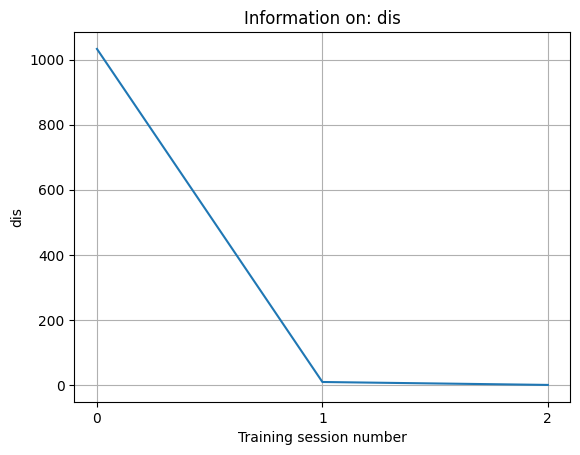

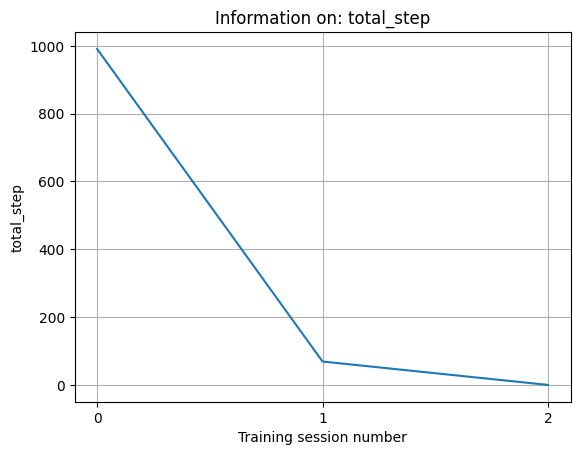

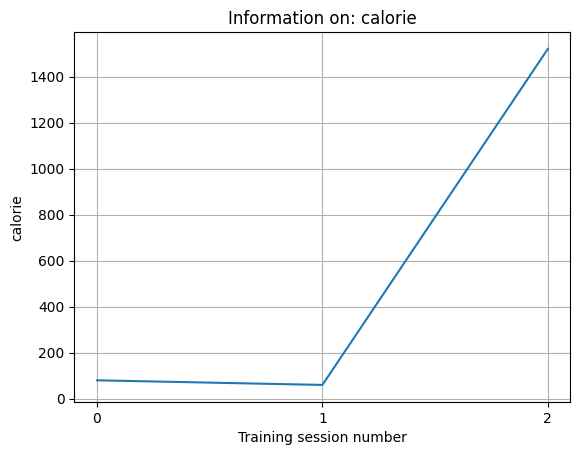

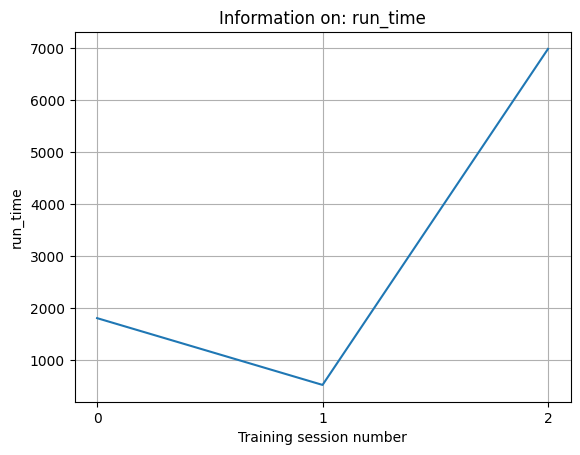

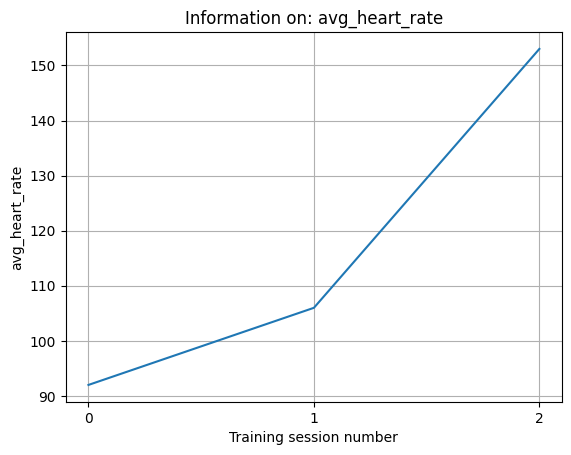

In [72]:

# import matplotlib.ticker as ticker

def show_graphs(exercise_history):
  for data in ["dis", "total_step",  "calorie", "run_time", "avg_heart_rate"]:
    y = []
    for item in exercise_history["data"]["summary"]:
      # print(item[data])
      y.append(float(item[data]))
    x = [ i for i in range(len(exercise_history["data"]["summary"])) ]
    # print(y)
    plt.title(f"Information on: {data}")
    plt.xlabel(f"Training session number")
    plt.ylabel(f"{data}")

    plt.plot(x, y)

    
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))  
    # plt.yticks(np.arange(min(x), max(x)+1, 0.3))  

    plt.grid()

    plt.show()

print(test_person.get_history())

show_graphs(test_person.get_history())

In [73]:
running_heartrate = pd.read_csv("running_summary.csv")

In [74]:
running_heartrate = running_heartrate[['heart_rate', 'total_running_time', 'total_calories', 'distance', 'avg_speed']].dropna()


In [75]:
running_train_dataset = running_heartrate.sample(frac=0.8, random_state=0)
running_test_dataset = running_heartrate.drop(running_train_dataset.index)

In [76]:
running_train_dataset

,heart_rate,total_running_time,total_calories,distance,avg_speed
3741,132.0,2922.0,75.0,9.65652,11.739665
142,136.0,485.0,65.0,1.65637,12.039677
1395,177.0,793.0,97.0,3.22275,13.628628
4760,139.0,2862.0,68.0,9.65792,11.780296
3680,177.0,898.0,103.0,3.22508,12.306212
...,...,...,...,...,...
4226,133.0,1474.0,88.0,4.82843,11.254320
2082,151.0,3236.0,93.0,11.26716,12.457276
5028,162.0,1354.0,103.0,4.82814,12.097601
370,150.0,2234.0,98.0,8.04716,13.315894


In [77]:
running_test_dataset

,heart_rate,total_running_time,total_calories,distance,avg_speed
0,143.0,436.0,78.0,1.61317,13.563011
7,151.0,572.0,29.0,2.08591,13.428711
21,162.0,2554.0,36.0,9.85039,13.428711
24,165.0,2977.0,35.0,11.44576,13.428711
25,169.0,3116.0,36.0,11.97024,13.428711
...,...,...,...,...,...
5606,150.0,903.0,82.0,3.22179,12.604560
5608,149.0,1813.0,103.0,6.43941,12.604560
5609,146.0,458.0,80.0,1.61227,13.452729
5614,148.0,469.0,93.0,1.61616,12.813799


In [78]:
running_train_features = running_train_dataset.copy()
running_test_features = running_test_dataset.copy()

running_train_labels = running_train_features.pop('heart_rate')
running_test_labels = running_test_features.pop('heart_rate')

In [79]:
running_train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
heart_rate,4402.0,149.030441,16.316665,63.000000,139.250000,150.000000,161.000000,205.000000
total_running_time,4402.0,1957.333485,1517.648537,1.000000,903.000000,1597.000000,2580.250000,14263.000000
total_calories,4402.0,81.807133,32.021867,0.000000,79.000000,92.000000,100.000000,219.000000
distance,4402.0,7.112361,5.391902,0.090060,3.220842,6.437385,9.657105,41.844780
avg_speed,4402.0,12.832776,1.199456,9.454794,11.999926,12.642837,13.568232,19.840473


In [80]:

import seaborn as sns

In [81]:
# sns.pairplot(running_train_dataset[['heart_rate', 'total_running_time', 'total_calories', 
#                                     'distance', 'avg_speed']], diag_kind='kde')

In [82]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

normalizer = tf.keras.layers.Normalization(axis=-1)

In [83]:
normalizer.adapt(np.array(running_train_features))
print(normalizer.mean.numpy())

first = np.array(running_train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


[[1957.3331      81.807144     7.1123595   12.832772 ]]
First example: [[2922.     75.      9.66   11.74]]

Normalized: [[ 0.64 -0.21  0.47 -0.91]]


In [84]:
# def build_and_compile_model(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(64, activation='relu'),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#   return model

In [85]:
# dnn_model = build_and_compile_model(normalizer)
# dnn_model.summary()


In [86]:
# %%time
# history = dnn_model.fit(
#     running_train_features,
#     running_train_labels,
#     validation_split=0.2,
#     verbose=0, epochs=100)

# # def plot_loss(history):
# #   plt.plot(history.history['loss'], label='loss')
# #   plt.plot(history.history['val_loss'], label='val_loss')
# #   plt.ylim([0, 10])
# #   plt.xlabel('Epoch')
# #   plt.ylabel('Error [MPG]')
# #   plt.legend()
# #   plt.grid(True)

# # plot_loss(history)

In [87]:
# test_results = {}
# test_results['dnn_model'] = dnn_model.evaluate(running_test_features, running_test_labels, verbose=0)
# print(test_results)

In [88]:
# running_test_features

In [89]:
# running_test_predictions = dnn_model.predict(running_test_features).flatten()

# a = plt.axes(aspect='equal')
# plt.scatter(running_test_labels, running_test_predictions)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# lims = [-50, 300]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [90]:
# running_test_predictions

In [91]:
# dnn_model.predict([436.0,	78.0,	1.61317,	13.563011])[0][0]

In [92]:
test_person.calc_heartrate(dnn_model)

Dist: 1.033, speed: 2.061419068736142, cal: 80.0
Actual H/R: 92.0
1/1 [==============================] - 0s 142ms/step
Calculated H/R: [[192.53769]]
Your heart rate is low


In [93]:
test_ex = list(test_person.program["Abdominals"]["Title"])[0]
test_ex

'Banded crunch isometric hold'

In [94]:
import random

# filling history with dummy data
for i in range(100):
  a = round(random.uniform(3, 25), 0)
  b = round(random.uniform(2, 50), 0)
  add_training_results_dummy(test_person, test_ex, 
                       a + (i // 8), 
                       b + (i // 8), 
                       round(random.uniform(30, 45), 0),
                       i,
                       datetime.datetime(2023, 5, 18) + datetime.timedelta(days= (i // 3) )
)
  
test_person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2023-05-18 00:00:00,2,31.0,20.0,36.0,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-19 00:00:00,3,36.0,10.0,38.0,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-05-18 00:00:00,0,48.0,5.0,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-05-18 00:00:00,1,4.0,15.0,42.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-05-19 00:00:00,4,15.0,16.0,44.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-06-18 00:00:00,95,30.0,24.0,34.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2023-06-19 00:00:00,96,55.0,21.0,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2023-06-19 00:00:00,97,16.0,26.0,31.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2023-06-19 00:00:00,98,19.0,21.0,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
print(test_person.history.index)


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')


In [96]:
def my_output(X, weights, biases):
    return tf.add(tf.multiply(X, weights), biases)

def loss_func(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))



def get_recommended_weights(tr_history, ex_name):
  x_vals =  tr_history[f"{ex_name}, reps"].astype(np.float32).to_numpy()
  y_vals = tr_history[f"{ex_name}, weight (kg)"].astype(np.float32).to_numpy()
  # plt.scatter(x_vals, y_vals)
  norm = np.linalg.norm(x_vals)     # To find the norm of the array
  # print(norm)                        # Printing the value of the norm
  normalized_array = x_vals/norm  # Formula used to perform array normalization
  # print(normalized_array)


  my_opt = tf.optimizers.SGD(learning_rate=0.02)
  tf.random.set_seed(1)
  np.random.seed(0)
  weights = tf.Variable(tf.random.normal(shape=[1])) 
  # print(weights)
  biases = tf.Variable(tf.random.normal(shape=[1])) 
  history = list()

  for i in range(len(x_vals)): 
    rand_index = np.random.choice(len(x_vals))
    rand_x = [normalized_array[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    history.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
  return weights, biases


In [97]:


# def update_weights(tr_history, ex_name, weight, reps):
#   # x_vals =  tr_history[f"{ex_name}, повторений"].astype(np.float32).to_numpy()
#   # print(type(x_vals))
#   # y_vals = tr_history[f"{ex_name}, вес (кг)"].astype(np.float32).to_numpy()
#   # # plt.scatter(x_vals, y_vals)
#   # norm = np.linalg.norm(x_vals)     # To find the norm of the array
#   # # print(norm)                        # Printing the value of the norm
#   # normalized_array = x_vals/norm  # Formula used to perform array normalization
#   # print(normalized_array)


#   my_opt = tf.optimizers.SGD(learning_rate=0.02)
#   tf.random.set_seed(1)
#   np.random.seed(0)
#   weights = tf.Variable(tf.random.normal(shape=[1])) 
#   # print(weights)
#   biases = tf.Variable(tf.random.normal(shape=[1])) 
#   history = list()

#   for i in range(len(x_vals)): 
#     rand_index = np.random.choice(len(x_vals))
#     rand_x = [normalized_array[rand_index]] 
#     rand_y = [y_vals[rand_index]]
#     with tf.GradientTape() as tape:
#         predictions = my_output(rand_x, weights, biases)
#         loss = loss_func(rand_y, predictions)
#     # print(loss)
#     history.append(loss.numpy())
#     gradients = tape.gradient(loss, [weights, biases])
#     my_opt.apply_gradients(zip(gradients, [weights, biases]))
#     if (i + 1) % 25 == 0: 
#         print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
#         print(f'Loss = {loss.numpy()}') 
#   plt.plot(history)
#   plt.xlabel('iterations')
#   plt.ylabel('loss')
#   plt.show()
#   return weights, biases

In [98]:

w, b = get_recommended_weights(test_person.history, test_ex)
print(my_output([30.0], w, b))

tf.Tensor([48.459618], shape=(1,), dtype=float32)


In [99]:
print(my_output([20.0], w, b))

tf.Tensor([39.02246], shape=(1,), dtype=float32)


In [100]:
# test_person.history["Date"].unique()

In [101]:
# test_person.history[f"Date"].astype(int)

<ipython-input-102-3b5452571623>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
<ipython-input-102-3b5452571623>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


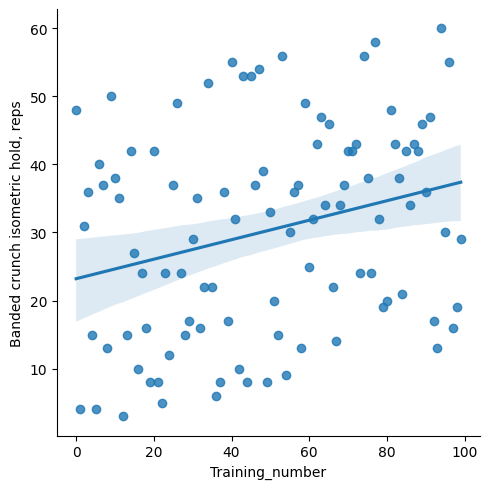

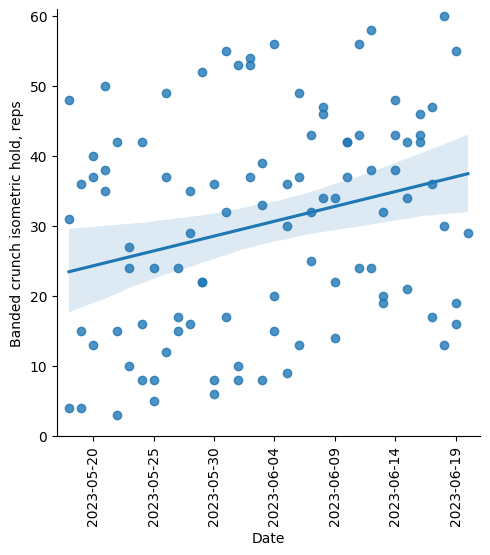

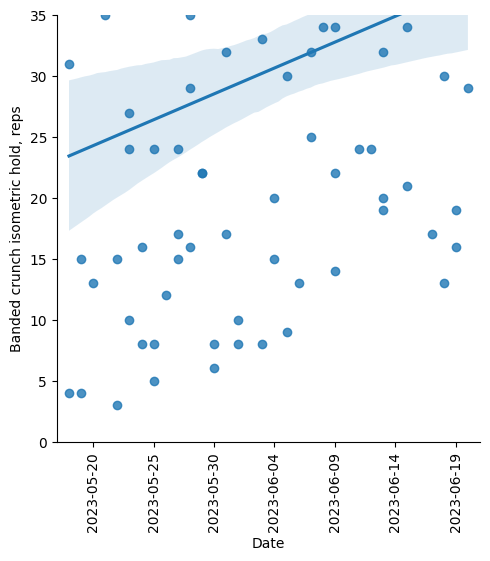

In [102]:
import seaborn as sns

def plot_reps(history, exercise):
  # df = df.astype({"a": int, "b": complex})
  history = history.astype({"Training_number": int, f"{exercise}, reps": float, f"{exercise}, weight (kg)": float})
  
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, reps" ,data=history, fit_reg=True) 
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, weight (kg)" ,data=history, fit_reg=True) 

  df_temp = history[["Date", f"{exercise}, reps", f"{exercise}, weight (kg)"]].copy()
  df_temp["dates"] = pd.to_datetime(history['Date']).apply(lambda date: date.toordinal())
  # print(df_temp["dates"])
  ax = sns.regplot(
    data=df_temp,
    x="dates",
    y=f"{exercise}, reps",
  )
  # Tighten up the axes for prettiness
  ax.set_xlim(df_temp['dates'].min() - 1, df_temp['dates'].max() + 1)
  ax.set_ylim(0, df_temp[f"{exercise}, reps"].max() + 1)
  # Replace the ordinal X-axis labels with nice, readable dates
  ax.set_xlabel('Date')
  new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
  ax.set_xticklabels(new_labels)
  ax.tick_params(axis='x', rotation=90)


def plot_weights(history, exercise):
  # df = df.astype({"a": int, "b": complex})
  history = history.astype({"Training_number": int, f"{exercise}, reps": float, f"{exercise}, weight (kg)": float})
  
  sns.lmplot(x=f"Training_number" ,y=f"{exercise}, weight (kg)" ,data=history, fit_reg=True) 

  df_temp = history[["Date", f"{exercise}, reps", f"{exercise}, weight (kg)"]].copy()
  df_temp["dates"] = pd.to_datetime(history['Date']).apply(lambda date: date.toordinal())
  # print(df_temp["dates"])
  ax = sns.regplot(
    data=df_temp,
    x="dates",
    y=f"{exercise}, reps",
  )
  # Tighten up the axes for prettiness
  ax.set_xlim(df_temp['dates'].min() - 1, df_temp['dates'].max() + 1)
  ax.set_ylim(0, df_temp[f"{exercise}, weight (kg)"].max() + 1)
  # Replace the ordinal X-axis labels with nice, readable dates
  ax.set_xlabel('Date')
  new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
  ax.set_xticklabels(new_labels)
  ax.tick_params(axis='x', rotation=90)


plot_reps(test_person.history, test_ex)
plot_weights(test_person.history, test_ex)

In [103]:
def get_predicted_weight(history, model, w, b, weights, reps):
  # print(history)
  pred_w = round(float(model(float(reps), w, b)), 2) / 2
  print(f"Predicted weights: {pred_w}, actual weights: {weights}")
  if pred_w > weights:
    print("Good weights, recommend increasing reps")
  else:
    print("Recommend increasing weights")

get_predicted_weight(test_person.history, my_output, w, b, 7, 10)

Predicted weights: 14.795, actual weights: 7
Good weights, recommend increasing reps


In [104]:

# filling history with dummy data
for i in range(101, 200):
  a = round(random.uniform(3, 25), 0)
  b = round(random.uniform(2, 50), 0)
  add_training_results(test_person, test_ex, 
                       a + (i // 8), 
                       b + (i // 8), 
                       round(random.uniform(30, 45), 0),
                       int(i // 3))
  
test_person.history

Predicted weights: 24.635, actual weights: 25.0
Recommend increasing weights
Predicted weights: 29.03, actual weights: 18.0
Good weights, recommend increasing reps
Predicted weights: 21.73, actual weights: 16.0
Good weights, recommend increasing reps
Predicted weights: 37.54, actual weights: 36.0
Good weights, recommend increasing reps
Predicted weights: 37.48, actual weights: 17.0
Good weights, recommend increasing reps
Predicted weights: 36.37, actual weights: 18.0
Good weights, recommend increasing reps
Predicted weights: 18.84, actual weights: 33.0
Recommend increasing weights
Predicted weights: 34.975, actual weights: 24.0
Good weights, recommend increasing reps
Predicted weights: 23.305, actual weights: 33.0
Recommend increasing weights
Predicted weights: 17.525, actual weights: 26.0
Recommend increasing weights
Predicted weights: 22.145, actual weights: 29.0
Recommend increasing weights
Predicted weights: 25.26, actual weights: 33.0
Recommend increasing weights
Predicted weights

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2023-05-18 00:00:00,2,31.0,20.0,36.0,26.0,10,42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-19 00:00:00,3,36.0,10.0,38.0,26.0,10,42,26.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-05-18 00:00:00,0,48.0,5.0,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-05-18 00:00:00,1,4.0,15.0,42.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-05-19 00:00:00,4,15.0,16.0,44.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-06-18 00:00:00,95,30.0,24.0,34.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2023-06-19 00:00:00,96,55.0,21.0,36.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2023-06-19 00:00:00,97,16.0,26.0,31.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2023-06-19 00:00:00,98,19.0,21.0,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:

w, b = get_recommended_weights(test_person.history, test_ex)
print(my_output([30.0], w, b))

tf.Tensor([69.07051], shape=(1,), dtype=float32)


# Example

### Creating a new user

In [106]:
person = User("Ivan", 25, 180, 90, "male", ex_type=1)
print(person)

Name: Ivan,
    Age: 25,
    Height: 180,
    Weight: 90,
    Gender: Gender.male,
    Calories daily: 3000,
    Calories today: 0,
    BMI: 27.777777777777775



### Generate a program for that user

In [107]:
person.generate_program()
print(person.show_program())

For bodypart Abdominals, recommend Banded crunch isometric hold
For bodypart Adductors, recommend Band Hip Adductions
For bodypart Abductors, recommend IT Band and Glute Stretch
For bodypart Biceps, recommend Incline dumbbell biceps curl
For bodypart Calves, recommend Smith machine standing calf raise
For bodypart Chest, recommend HM Banded Cross-Over Pull
For bodypart Forearms, recommend Standing alternating band speed row
For bodypart Glutes, recommend Alternating standing glute stretch
For bodypart Hamstrings, recommend Standing Hamstring and Calf Stretch
For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
For bodypart Lower Back, recommend Yoga plex
For bodypart Middle Back, recommend Partner side plank band row
For bodypart Traps, recommend Snatch Shrug
For bodypart Neck, recommend Lying Face Down Plate Neck Resistance
For bodypart Quadriceps, recommend Speed Box Squat
For bodypart Shoulders, recommend Rack Delivery
For bodypart Triceps, recommend Band overhead triceps p

### Let us show what happens if food is eaten

In [108]:


food_list = ["Egg", "Pie", "Chicken", "Sandwich, Spaghetti"]

person.calories_calculation(food_list)

[['Яйца', 'Eggs', 15.0, 13.0, 1.0, 162]]
[['Соленый огурец', 'Pickle', 1.0, 0.0, 3.0, 14]]
[['Курица', 'Chicken', 21.0, 11.0, 1.0, 186]]
[[nan, 'Steamed beef patties', 11.3, 16.7, 5.9, 193]]
Total 555 kcal eaten today
Some foods you can eat today:
<class 'pandas.core.frame.DataFrame'>
apricots, kilo calories - 45
Avocado, kilo calories - 197
Adjika, kilo calories - 59
Quince, kilo calories - 41
Iceberg, kilo calories - 17
Activia kefir 1%, kilo calories - 39
A pineapple, kilo calories - 50
Canned pineapple, kilo calories - 65
candied pineapple, kilo calories - 78
Orange, kilo calories - 43
Orange juice, kilo calories - 44


### Set a new daily calorie limit, reset daily calories and try other food

In [109]:
person.reset_calories_today()
person.set_calories_limit(400)

new_food_list = ["Cheese", "Oatmeal"]
person.calories_calculation(new_food_list)

[['Сыр 45%', 'Cheese 45%', 26.0, 26.0, 0.0, 336]]
[['Овсянка', 'Oatmeal', 9.0, 5.0, 46.0, 271]]
Total 607 kcal eaten today
You are over limit on daily calories, recommend an exercise
You are 207 kcal overlimit
The following activites can be suggested:
Dancing: disco, ballroom, square for 29 minutes
Mowing Lawn: push, hand for 29 minutes
Carrying & stacking wood for 32 minutes
Gardening: general for 35 minutes
Aerobics: water for 40 minutes
Badminton: general for 40 minutes
Walking: 3.5 mph (17 min/mi) for 42 minutes
Volleyball: non-competitive, general play for 53 minutes
Dancing: slow, waltz, foxtrot for 53 minutes
Cooking for 81 minutes
Horseback Riding: general for 81 minutes
Sleeping for 266 minutes



### Add an exercise after training session

In [110]:
# So that the example works, as the program is be generated
test_exec = [x['Title'].tolist()[0] for x in person.program.values()][0]

add_training_results_dummy(person, test_exec, 10, 26, 42, 2, date=datetime.datetime(2020, 5, 18))
person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Lying Face Down Plate Neck Resistance, rest (s)","Speed Box Squat, reps","Speed Box Squat, weight (kg)","Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Can change an exercise from the program 

In [111]:
print("Before:")
print(person)
change_exercise(person, "Abdominals", "Chest", df_gym_cat)
print("\n\nAfter:")
print(person)

Before:
Name: Ivan,
    Age: 25,
    Height: 180,
    Weight: 90,
    Gender: Gender.male,
    Calories daily: 400,
    Calories today: 607,
    BMI: 27.777777777777775
For bodypart Abdominals, recommend Banded crunch isometric hold
For bodypart Adductors, recommend Band Hip Adductions
For bodypart Abductors, recommend IT Band and Glute Stretch
For bodypart Biceps, recommend Incline dumbbell biceps curl
For bodypart Calves, recommend Smith machine standing calf raise
For bodypart Chest, recommend HM Banded Cross-Over Pull
For bodypart Forearms, recommend Standing alternating band speed row
For bodypart Glutes, recommend Alternating standing glute stretch
For bodypart Hamstrings, recommend Standing Hamstring and Calf Stretch
For bodypart Lats, recommend UN Band Assisted Pull-up Neutral
For bodypart Lower Back, recommend Yoga plex
For bodypart Middle Back, recommend Partner side plank band row
For bodypart Traps, recommend Snatch Shrug
For bodypart Neck, recommend Lying Face Down Plate N

In [112]:
person.history

,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)","Crunches, reps","Crunches, weight (kg)","Crunches, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Can locate nearby sports ground based on location

Use Pokrovka HSE Campus as an example of coordinates

In [113]:
HSE_long = 37.64823890522192
HSE_lat = 55.75362365163729

In [114]:
req_str = f"https://search-maps.yandex.ru/v1/?"\
  "text=Спортивная площадка&"\
  f"ll={HSE_long},{HSE_lat}&"\
  "spn=0.552069,0.550552&"\
  "type=biz&"\
  "results=15&"\
  "lang=ru_RU&"\
  f"apikey={ya_api}"
# print(req_str)

x = requests.get(req_str)
gym_coordinates = get_all_coordinates(x)

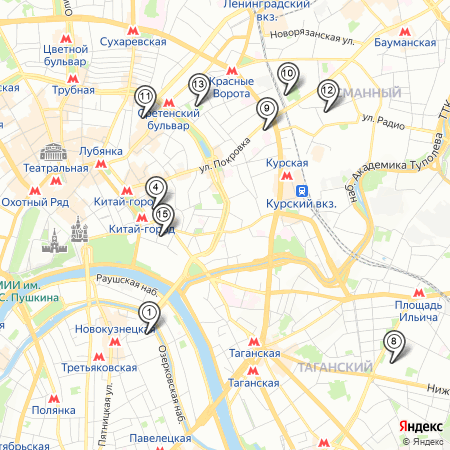

In [115]:
HSE_map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={HSE_long},{HSE_lat}&size=450,450&z=13&l=map&pt={points_create(gym_coordinates)}""")
display(Image(HSE_map.content))

### Now suppose we walk along a line near by close-by sport grounds

In [116]:

long_start = 37.63912337086539
lat_start = 55.7531586027803

In [117]:

long_end = 37.63468163273671
lat_end = 55.75671621603898

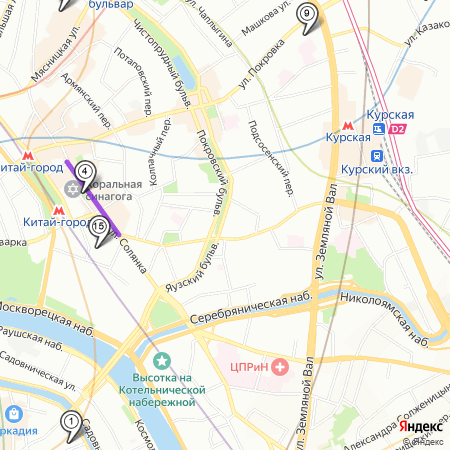

In [118]:

points = get_all_coordinates(x)

map = requests.get(f"""https://static-maps.yandex.ru/1.x/?ll={HSE_long},{HSE_lat}&size=450,450&z=14&l=map&pt={points_create(points)}"""\
                   f"&pl={long_start},{lat_start},{long_end},{lat_end}")
display(Image(map.content))

### So here the service shows nearby locations and distance to them

the cycle is a rough simulation of walking along the line, on each step find the closest

In [119]:


steps = 100
dist = 0.01

for i in range(steps):
  cur_lat = lat_start + (lat_end - lat_start) * i / steps
  cur_long = long_start + (long_end - long_start) * i / steps
  find_closes_gym(cur_long, cur_lat, points)

Closest point is 15, in 195.3 meters!
Notification sent, point 15. distance 195.3
Closest point is 15, in 192.24 meters!
Closest point is 15, in 189.32 meters!
Closest point is 15, in 186.52 meters!
Closest point is 15, in 183.85 meters!
Closest point is 15, in 181.32 meters!
Closest point is 15, in 178.94 meters!
Closest point is 15, in 176.71 meters!
Closest point is 15, in 174.63 meters!
Closest point is 15, in 172.72 meters!
Closest point is 15, in 170.98 meters!
Closest point is 15, in 169.41 meters!
Closest point is 15, in 168.02 meters!
Closest point is 15, in 166.81 meters!
Closest point is 15, in 165.79 meters!
Closest point is 15, in 164.95 meters!
Closest point is 15, in 164.31 meters!
Closest point is 15, in 163.87 meters!
Closest point is 15, in 163.62 meters!
Closest point is 15, in 163.57 meters!
Closest point is 15, in 163.72 meters!
Closest point is 15, in 164.07 meters!
Closest point is 15, in 164.61 meters!
Closest point is 15, in 165.35 meters!
Closest point is 15, 

### Can show graphical info on progress

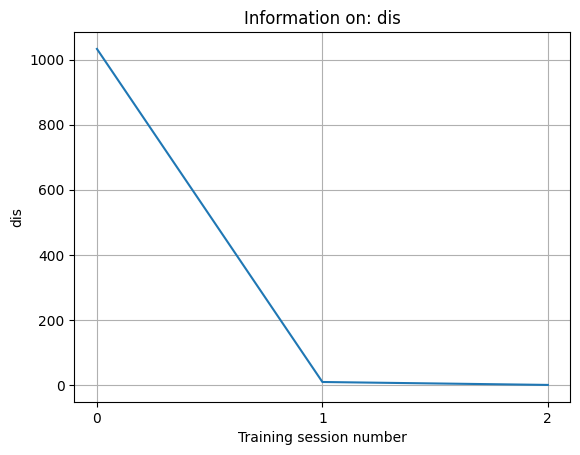

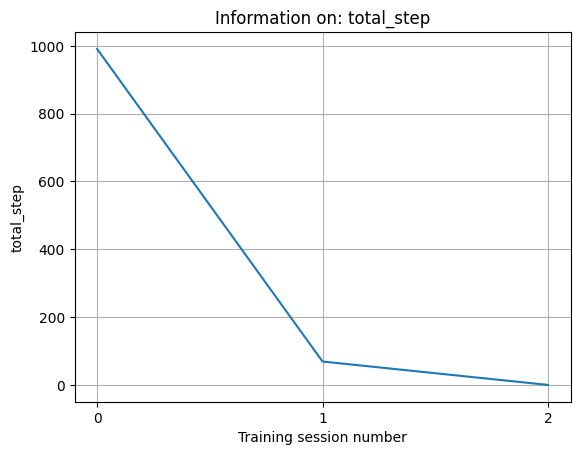

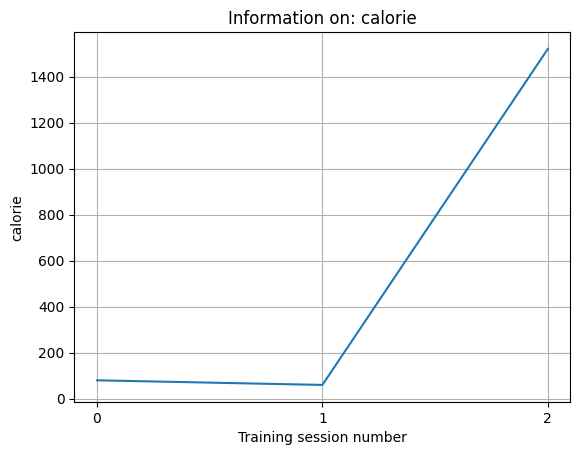

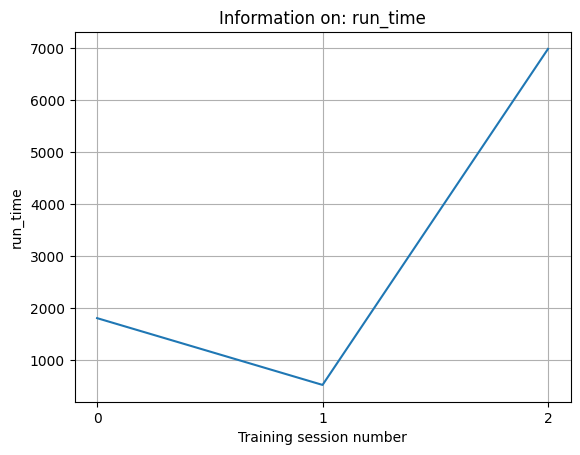

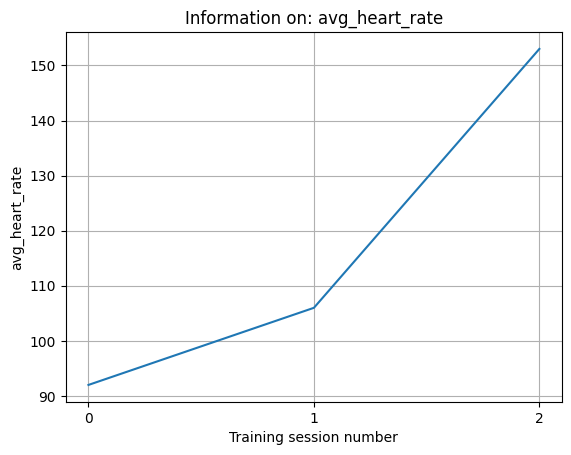

In [120]:
show_graphs(person.get_history())

Can try to claculate and predict the heartbeat rat, then compare it with the one from user's training

In [121]:
person.calc_heartrate(dnn_model)

Dist: 1.033, speed: 2.061419068736142, cal: 80.0
Actual H/R: 92.0
1/1 [==============================] - 0s 71ms/step
Calculated H/R: [[192.53769]]
Your heart rate is low


For some given exercise, can plot user's progress

In [122]:
# Get the exercise from the program to examie
test_ex = list(person.program["Abdominals"]["Title"])[0]
test_ex

'Crunches'

In [123]:

add_training_results(person, "Lateral Band Walk", 10, 26, 42, 0, date=datetime.datetime(2023, 5, 19))
person.history

Wrong exercise!


,Date,Training_number,"Banded crunch isometric hold, reps","Banded crunch isometric hold, weight (kg)","Banded crunch isometric hold, rest (s)","Band Hip Adductions, reps","Band Hip Adductions, weight (kg)","Band Hip Adductions, rest (s)","IT Band and Glute Stretch, reps","IT Band and Glute Stretch, weight (kg)",...,"Speed Box Squat, rest (s)","Rack Delivery, reps","Rack Delivery, weight (kg)","Rack Delivery, rest (s)","Band overhead triceps press, reps","Band overhead triceps press, weight (kg)","Band overhead triceps press, rest (s)","Crunches, reps","Crunches, weight (kg)","Crunches, rest (s)"
0,2020-05-18 00:00:00,2,26.0,10,42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# filling history with dummy data
for i in range(100):
  a = round(random.uniform(7, 30), 0)
  b = round(random.uniform(15, 25), 0)
  add_training_results(person, test_ex, 
                       a + (i // 8), 
                       b + (i // 8), 
                       round(random.uniform(30, 45), 0),
                       i,
                       datetime.datetime(2023, 5, 18) + datetime.timedelta(days= (i // 3) )
)
  

Predicted weights: 13.675, actual weights: 25.0
Recommend increasing weights
Predicted weights: 16.425, actual weights: 28.0
Recommend increasing weights
Predicted weights: 13.535, actual weights: 22.0
Recommend increasing weights
Predicted weights: 17.87, actual weights: 23.0
Recommend increasing weights
Predicted weights: 21.53, actual weights: 11.0
Good weights, recommend increasing reps
Predicted weights: 21.815, actual weights: 17.0
Good weights, recommend increasing reps
Predicted weights: 20.06, actual weights: 18.0
Good weights, recommend increasing reps
Predicted weights: 17.145, actual weights: 17.0
Good weights, recommend increasing reps
Predicted weights: 18.015, actual weights: 27.0
Recommend increasing weights
Predicted weights: 24.26, actual weights: 24.0
Good weights, recommend increasing reps
Predicted weights: 19.69, actual weights: 20.0
Recommend increasing weights
Predicted weights: 25.835, actual weights: 21.0
Good weights, recommend increasing reps
Predicted weigh

<ipython-input-102-3b5452571623>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
<ipython-input-102-3b5452571623>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


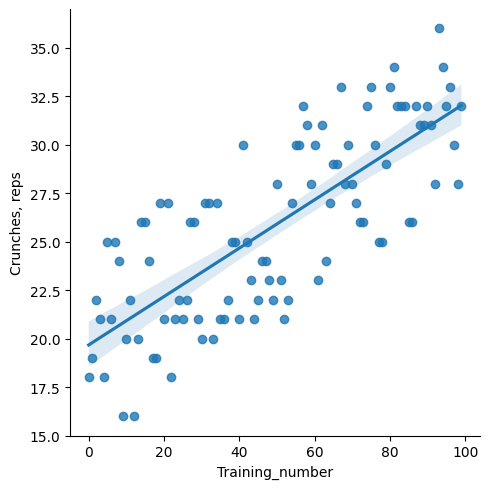

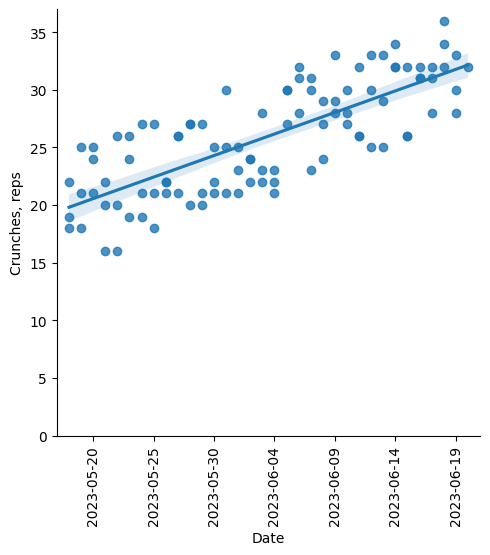

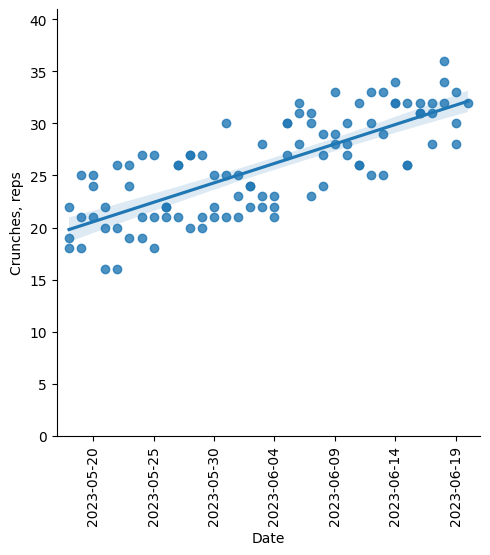

In [125]:



plot_reps(person.history, test_ex)
plot_weights(person.history, test_ex)